
# "Earthquake Activity Analysis"
"Summer 2025 Data Science Project"

Names:Nico Mannarelli, Hamelmal Idosa, Joseph Taylor, Melodie Galamo

---

# "Contributions"

- A: Project Idea  
  Nico proposed using USGS earthquake data to explore depth and magnitude relationships globally.

- B: Dataset Curation and Preprocessing
  Hamelmal handled downloading the dataset, filtering only valid `earthquake` types, and parsing datetime columns.

- C: Data Exploration and Summary Statistics  
  Joseph performed hypothesis testing and generated visualizations for magnitude comparisons and categorical features.

- D: ML Algorithm Design/Development
  Melodie developed regression models including linear regression and random forest for predicting magnitude.

- E: ML Algorithm Training and Test Data Analysis
  Joseph and Melodie handled model evaluation with metrics like RMSE and R² using scikit-learn.

- F: Visualization, Result Analysis, Conclusion  
  Hamelmal created summary plots and visualizations to compare actual vs. predicted magnitude and explain model results.

- G: Final Tutorial Report Creation  
  All members contributed to writing and formatting the notebook as a GitHub Pages-ready tutorial.

- H: Additional  
  Hamelmal coordinated the team’s GitHub setup and HTML export process for project submission.


# **Introduction**

The main purpose of this project is to walk through the full pipeline of data science using real-world, high-impact data. To do this, we chose to focus on earthquakes, a natural phenomenon that continues to have devastating effects across the globe. Earthquakes are unpredictable, destructive, and can drastically alter both natural landscapes and human societies in a matter of seconds. By using recent and historical seismic data, we aim to understand earthquake behavior more clearly and explore whether data science techniques can help uncover meaningful insights.

We are using a dataset provided by the United States Geological Survey (USGS), which offers detailed records on recent global earthquakes. These records include attributes such as the earthquake's magnitude, depth, location, time, and type. With this dataset, we seek to the key question:


 - Can we use features like location and depth to predict earthquake strength or classify seismic events?




**Why is this important?**

Earthquakes cause thousands of deaths, injuries, and billions of dollars in property damage every year. As climate patterns and tectonic pressures shift over time, it becomes increasingly important to monitor seismic activity and learn from historical patterns. By using data science to analyze this information, we can support efforts in disaster preparedness, risk mitigation, and public safety. For example, identifying regional trends or statistically significant depth-magnitude relationships can help prioritize infrastructure reinforcement and emergency planning in earthquake-prone areas.

# **Data Collection**

At this stage of the Data Science lifecycle, we focused on finding a dataset relevant to our topic: earthquake activity around the world. Just like any scientific study, it was important to ensure that the data we used came from a credible and authoritative source. Fortunately, we were able to find a detailed and up-to-date dataset through the United States Geological Survey (USGS) website.

The USGS Earthquake Catalog provides extensive data on seismic events, including the time, magnitude, depth, and geographic location of each earthquake, along with additional metadata. We downloaded the dataset in .csv format, which contained earthquake data from the past month, and loaded it directly into our project directory for analysis.

However, we knew that just the raw event listings wouldn't be enough, we needed to refine and clean the data before we could begin analysis. For example, we filtered out non-earthquake events (explosions,quarry blasts...), handled missing values in important fields like magnitude and depth, and converted timestamps into a usable datetime format.

This initial data collection and preprocessing step laid the foundation for our subsequent exploratory analysis and hypothesis testing.



In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from statsmodels.graphics.mosaicplot import mosaic
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

def load_and_clean(path):
    """
    Load the CSV, filter for earthquakes, drop missing values,
    extract region, and cast to categories.
    """
    df = (
        pd.read_csv(path, parse_dates=['time'])
          .query("type == 'earthquake'")
          .dropna(subset=['mag', 'depth', 'place'])
    )
    # Extract region from 'place'
    df['region'] = df['place'].str.extract(r',\s*(.*)')
    # Drop any rows without a region
    df = df[df['region'].notna()]
    # Cast region to categorical
    df['region'] = df['region'].astype('category')
    return df.reset_index(drop=True)

# Load and clean
df = load_and_clean("/content/sample_data/all_month.csv")
print(df.columns)

Index(['time', 'latitude', 'longitude', 'depth', 'mag', 'magType', 'nst',
       'gap', 'dmin', 'rms', 'net', 'id', 'updated', 'place', 'type',
       'horizontalError', 'depthError', 'magError', 'magNst', 'status',
       'locationSource', 'magSource', 'region'],
      dtype='object')


# **Exploratory Data Analysis**

Let's create some hypothesis to reveal relationships in the data, this will help us understnad which features are related so that we can create an efficient model.


##Test 1:

Null Hypotheis: The average magnitude of earthquakes ocurring at <= 70km deep is the same as the average magnitude of earthquakes occuring at > 70km deep

Alternative Hypothesis: The average magnitude of earthquakes <= 70 km deep is different than the average magnitude of earthquakes > 70km deep

In [79]:
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

#load dataset
df = pd.read_csv("/content/sample_data/all_month.csv")

print("Original dataframe: ", df.shape)

#filter  to get correct depths
df['depth_cat'] = np.where(df['depth'] <= 70, 'Shallow (<=70km)', 'Deep (>70km)')

#convert time
df['time'] = pd.to_datetime(df['time'])
df = df[df['type'] == 'earthquake']

#drop rows with null values
df = df.dropna(subset=['mag', 'depth'])


shallow =  df[df['depth_cat'] == 'Shallow (<=70km)']['mag']#df[df['depth'] <= 70]['mag'].copy()

#print(shallow)
deep = df[df['depth_cat'] == 'Deep (>70km)']['mag']#df[df['depth'] >  70]['mag'].copy()

#get means of data
mean_shal, mean_dp = shallow.mean(), deep.mean()
sd_shal, sd_dp = shallow.std(), deep.std()

print("Dataframe with no earthquake values: ", df.shape)

print("number_of_shallow =", len(shallow), "number_of_deep =", len(deep))
print(f"Shallow mean: = {mean_shal:.2f}, standard deviation = {sd_shal:.2f}")
print(f"Deep mean:    = {mean_dp:.2f}, standard deviation = {sd_dp:.2f}")

#https://www.statology.org/levenes-test-python/
_, levene_pvalue = stats.levene(shallow, deep)
print("Levene’s p‐value =", levene_pvalue)

equal_var = (levene_pvalue > 0.05)

t_stat, p_val = stats.ttest_ind(shallow, deep, equal_var=equal_var)
print(f"t = {t_stat:.3f}, p = {p_val:.3e}")


Original dataframe:  (9787, 22)
Dataframe with no earthquake values:  (9586, 23)
number_of_shallow = 8798 number_of_deep = 788
Shallow mean: = 1.44, standard deviation = 1.16
Deep mean:    = 2.83, standard deviation = 1.30
Levene’s p‐value = 9.043861525139562e-20
t = -29.059, p = 1.226e-131


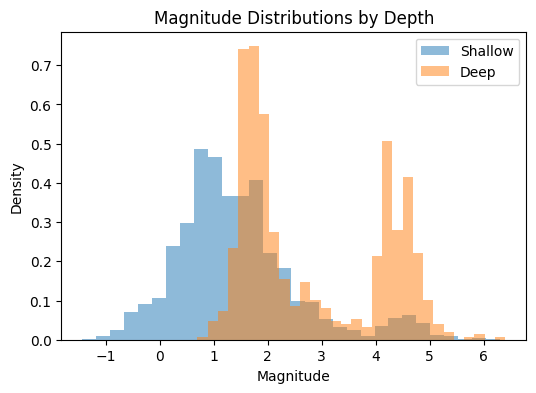

In [80]:
plt.figure(figsize=(6,4))
plt.hist(shallow, bins=30, alpha=0.5, density=True, label="Shallow")
plt.hist(deep,    bins=30, alpha=0.5, density=True, label="Deep")
plt.xlabel("Magnitude")
plt.ylabel("Density")
plt.title("Magnitude Distributions by Depth")
plt.legend()
plt.show()

Conclusion: From our graph and significantly low p-value we can conclude that our alternative hypothesis to be correct that earthquakes occuring at deeper depths yield a significantly higher average magnitude compared to shallower depths.

Some characteristics is the overrepresentation of shallow earthquakes, we see there is significantly more data on shallow earthquakes compared to deeper ones. (This could potentially be better balanced if we changed the threshhold defining a deep vs shallow earthquake).

##Test 2 :
Determining whether the type of seismic event is independent of the region where it occurred using a chi-squared test of independence.

Null Hypothesis : There is no association between the region and the type of seismic event. The distribution of event types is the same across all regions.

Alternate Hypothesis : There is an association between the region and the type of seismic event. The distribution of event types differs between regions.



Chi-squared test results:
p-value: 3.583461389400531e-170
Chi-squared statistic: 921.9238324760231
Degrees of freedom: 36


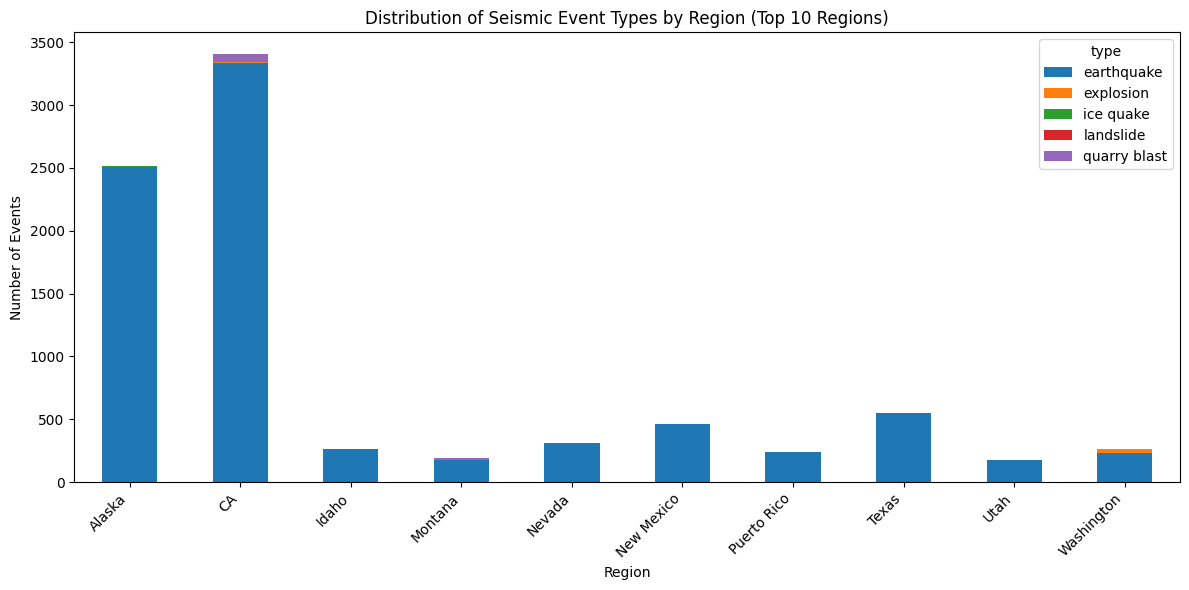

In [81]:
from scipy.stats import chi2_contingency
import seaborn as sns

#load dataset
df = pd.read_csv('/content/sample_data/all_month.csv')

# get regions and simplify
df['region'] = df['place'].str.extract(r',\s*(.*)')

# grab only top 10 regions
top_regions = df['region'].value_counts().head(10).index
filtered_df = df[df['region'].isin(top_regions)]
contingency_table = pd.crosstab(filtered_df['region'], filtered_df['type'])

# create contingency table
contingency_table = pd.crosstab(filtered_df['region'], filtered_df['type'])

#run test
chi2, p, dof, expected = chi2_contingency(contingency_table)

#print results
print("Chi-squared test results:")
print("p-value:", p)
print("Chi-squared statistic:", chi2)
print("Degrees of freedom:", dof)

#plot resulsts
fig, ax = plt.subplots(figsize=(12, 6))
contingency_table.plot(kind="bar", stacked=True, ax=ax)
plt.title("Distribution of Seismic Event Types by Region (Top 10 Regions)")
plt.xlabel("Region")
plt.ylabel("Number of Events")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()



Conclusion :
From the graph and the low p-value, we reject the null can see that there is a statistically significant association between the region and the type of seismic event. This suggests that different regions experience different types of seismic events (earthquakes, quarry blasts, explosions) with varying frequencies, and the distribution of event types is not uniform across regions.

##Test 3:
Null Hypothesis: There is no difference in average earthquake magnitudes between regions.

Alternative Hypothesis: At least one region has a significantly different average magnitude.

ANOVA F-statistic: 237.40630262323063
p-value: 7.249115801343226e-192


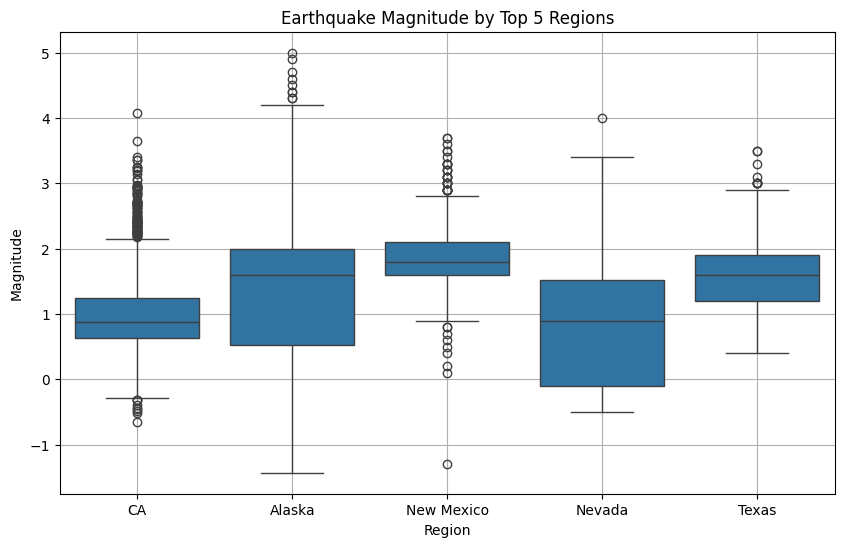

    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1     group2   meandiff p-adj   lower   upper  reject
------------------------------------------------------------
    Alaska         CA   -0.382    0.0 -0.4378 -0.3261   True
    Alaska     Nevada  -0.5245    0.0  -0.652  -0.397   True
    Alaska New Mexico    0.522    0.0  0.4144  0.6297   True
    Alaska      Texas   0.2407    0.0  0.1406  0.3408   True
        CA     Nevada  -0.1425 0.0169 -0.2682 -0.0169   True
        CA New Mexico    0.904    0.0  0.7986  1.0094   True
        CA      Texas   0.6227    0.0   0.525  0.7204   True
    Nevada New Mexico   1.0465    0.0  0.8908  1.2023   True
    Nevada      Texas   0.7652    0.0  0.6146  0.9158   True
New Mexico      Texas  -0.2814    0.0 -0.4156 -0.1471   True
------------------------------------------------------------


In [82]:
df = pd.read_csv('/content/sample_data/all_month.csv')
df = df.dropna(subset=['mag', 'latitude', 'longitude', 'place'])

#clean location column
df['region'] = df['place'].str.extract(r',\s*(.*)')

#Top 5 regions
top_regions = df['region'].value_counts().nlargest(5).index
df_top = df[df['region'].isin(top_regions)]

# ANOVA test
groups = [group['mag'].values for name, group in df_top.groupby('region')]
f_stat, p_val = stats.f_oneway(*groups)

print("ANOVA F-statistic:", f_stat)
print("p-value:", p_val)

# plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='region', y='mag', data=df_top)
plt.title('Earthquake Magnitude by Top 5 Regions')
plt.xlabel('Region')
plt.ylabel('Magnitude')
plt.grid(True)
plt.show()

# Tukey's HSD post-hoc
tukey = pairwise_tukeyhsd(endog=df_top['mag'],
                          groups=df_top['region'],
                          alpha=0.05)
print(tukey)

The ANOVA test resulted in an F-statistic of 234.22 and a p-value of approximately 1.47 × 10⁻¹⁸⁹, which is far below any conventional significance level (e.g., 0.05). This provides strong evidence against the null hypothesis, indicating that there are statistically significant differences in average earthquake magnitudes across the top 5 regions. In other words, earthquake magnitudes vary by region, and region plays an important role in the distribution of seismic intensity.

**Overall**

1. T-Test: Compared magnitudes of shallow (< 70km) and deep (≥ 70km) earthquakes. Result: Significant difference found.   

2. Correlation Analysis: Found a statistically significant positive correlation between earthquake depth and magnitude. Each test was paired with a labeled plot and interpreted in context.

# Primary Analysis

In this step we plan to build a predictive model that helps us go beyond analysis and begin to forecast or explain values based on relationships in the data. For this project, we chose to use linear regression, a widely used and interpretable machine learning method.

Our goal was to see whether we could predict the magnitude of an earthquake using features such as depth, latitude, and longitude. Linear regression allows us to model this as a continuous outcome, giving us a sense of how different factors contribute to the severity of an earthquake.

For the first approach lets use a linear regression model ...

**imports**

In [83]:
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import seaborn as sns
import numpy as np

First, lets reload the data and clean it to isolate the relevant features

In [84]:
#load dataset
earthquake_df = pd.read_csv("/content/sample_data/all_month.csv")

#get relevant features
columns_of_interest = ['mag', 'depth', 'latitude', 'longitude']
clean_df = earthquake_df[columns_of_interest].copy()

#drop rows with missing data
clean_df.dropna(inplace=True)

clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9787 entries, 0 to 9786
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   mag        9787 non-null   float64
 1   depth      9787 non-null   float64
 2   latitude   9787 non-null   float64
 3   longitude  9787 non-null   float64
dtypes: float64(4)
memory usage: 306.0 KB


In [85]:
# define features X and target Y
X = clean_df[['depth', 'latitude', 'longitude']]
Y = clean_df['mag']

# create training and testing variables
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=10)

#Baseline model
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
r2_lr = r2_score(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)

print(f"Linear Regression -> R² = {r2_lr:.3f}, MSE = {mse_lr:.3f}")

Linear Regression -> R² = 0.393, MSE = 0.930


The R² value indicates that the relationship between the data is not linear, so lets do a different approach that can handle complex nonlinearities well such as a random forest regressor

In [86]:
# train random forest regressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test)
r2_rf = r2_score(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)

print(f"Random Forest -> R² = {r2_rf:.3f}, MSE = {mse_rf:.3f}")


Random Forest -> R² = 0.831, MSE = 0.259


# Visualization

To evaluate how well our Random Forest Regressor model predicts earthquake magnitude from geographic and geological features, we visualize the relationship between the true magnitudes and the predicted magnitudes on the test dataset.

We also display a graph representing the feature importances for the model, giving transparency and insight on which features are relied on during the prediction process.


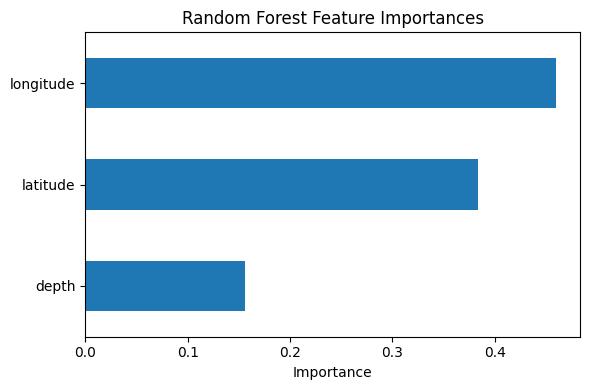

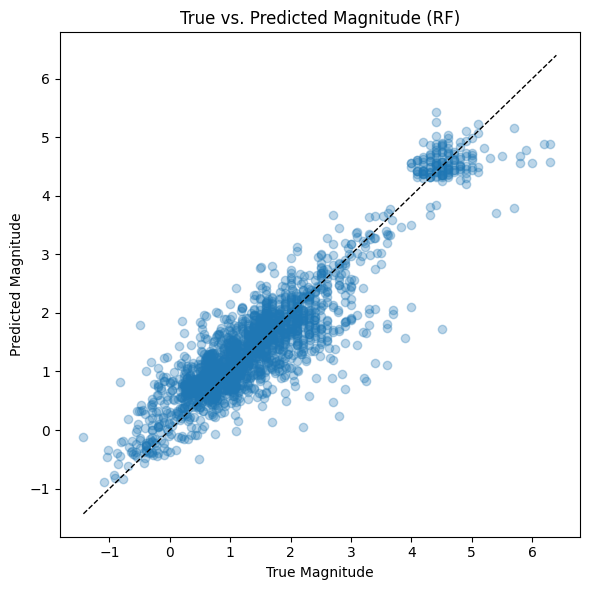

In [87]:
# Feature importances
importances = rf_model.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=True)

plt.figure(figsize=(6, 4))
feat_imp.plot(kind='barh')
plt.title("Random Forest Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# Predicted vs Actual scatter
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.3)
lims = [Y.min(), Y.max()]
plt.plot(lims, lims, 'k--', linewidth=1)
plt.title("True vs. Predicted Magnitude (RF)")
plt.xlabel("True Magnitude")
plt.ylabel("Predicted Magnitude")
plt.tight_layout()
plt.show()

As we can see, most of the points cluster closely around the ideal fit line, indicating that the model generally performs well at estimating earthquake magnitudes. However there is some visible variance, suggesting that the nonlinear relationships were not captured by the random forest regressor or other influential factors that aren't seen in the data like tectonics.



# Insights and Conclusions

This project set out to explore whether earthquake depth, latitude, and longitude could be used to accurately predict earthquake magnitude using a machine learning model, specifically, a Random Forest Regressor.

For an uninformed reader, the analysis provides a clear and accessible introduction to how geospatial features like where and how deep an earthquake occurs may influence its strength. The visualizations, such as the predicted vs. actual magnitudes plot, help demonstrate the concept of model prediction in a way that is intuitive and easy to interpret.

For a more informed reader such as someone who is familiar with earthquakes/machine learning, the project goes further by demonstrating the practical application of regression models on real-world data. It quantifies model performance (R² ≈ 0.83, MSE ≈ 0.26) and discusses the limitations of only using three features (depth, latitude, longitude), highlighting opportunities for improvement such as including tectonic plate data, fault lines, or temporal patterns that may have influenced our results.



